In [1]:
import sys
sys.path.insert(1, '../model')
import model

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import ScalarFormatter
import optuna
optuna.logging.disable_default_handler()
import pandas as pd
pd.plotting.register_matplotlib_converters()
import seaborn as sns
from scipy.integrate import solve_ivp

In [3]:
raw = pd.read_csv("../data/covid_19_data.csv")

In [4]:
raw

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
14806,14807,04/13/2020,Wyoming,US,2020-04-13 23:15:42,275.0,1.0,0.0
14807,14808,04/13/2020,Xinjiang,Mainland China,2020-04-13 23:15:42,76.0,3.0,73.0
14808,14809,04/13/2020,Yukon,Canada,2020-04-13 23:15:42,8.0,0.0,0.0
14809,14810,04/13/2020,Yunnan,Mainland China,2020-04-13 23:15:42,184.0,2.0,174.0


In [5]:
data_cols = ["Infected", "Deaths", "Recovered"]
data_cols_all = ["Confirmed", "Infected", "Deaths", "Recovered"]
df = raw.rename({"ObservationDate": "Date", "Province/State": "Province"}, axis=1)
df["Date"] = pd.to_datetime(df["Date"])
df["Country"] = df["Country/Region"]
df.loc[df["Country"] == "Diamond Princess", ["Country", "Province"]] = ["Others", "Diamond Princess"]
df["Infected"] = df["Confirmed"] - df["Deaths"] - df["Recovered"]
df[data_cols_all] = df[data_cols_all].astype(np.int64)
ncov_df_ungrouped = df.loc[:, ["Date", "Country", "Province", *data_cols_all]]
ncov_df_ungrouped.tail()

,Date,Country,Province,Confirmed,Infected,Deaths,Recovered
14806,2020-04-13,US,Wyoming,275,274,1,0
14807,2020-04-13,Mainland China,Xinjiang,76,0,3,73
14808,2020-04-13,Canada,Yukon,8,8,0,0
14809,2020-04-13,Mainland China,Yunnan,184,8,2,174
14810,2020-04-13,Mainland China,Zhejiang,1267,27,1,1239


In [6]:
df_germany = ncov_df_ungrouped.loc[ncov_df_ungrouped["Country"] == "Germany", :].groupby("Date").sum()
df_germany['Country'] = 'Germany'
df_germany['Province'] = None
df_germany

,Confirmed,Infected,Deaths,Recovered,Country,Province
Date,,,,,,
2020-01-28,4,4,0,0,Germany,None
2020-01-29,4,4,0,0,Germany,None
2020-01-30,4,4,0,0,Germany,None
2020-01-31,5,5,0,0,Germany,None
2020-02-01,8,8,0,0,Germany,None
...,...,...,...,...,...,...
2020-04-09,118181,63167,2607,52407,Germany,None
2020-04-10,122171,65491,2767,53913,Germany,None
2020-04-11,124908,64772,2736,57400,Germany,None


In [7]:
df_test = pd.read_csv("../data/full-list-total-tests-for-covid-19.csv")
df_test.rename({"Cumulative total tests": "TotalTests"}, axis=1,inplace=True)
df_test["Date"] = pd.to_datetime(df_test["Date"])
df_test_germany = df_test[df_test['Entity'] == 'Germany']
df_test_germany.tail()

,Entity,Code,Date,TotalTests
440,Germany,DEU,2020-03-08,87863
441,Germany,DEU,2020-03-15,215320
442,Germany,DEU,2020-03-22,563939
443,Germany,DEU,2020-03-29,924903
444,Germany,DEU,2020-04-05,1317887


In [8]:
result = pd.merge(df_germany,
                 df_test_germany[['Date','TotalTests']],
                 on='Date',
                 how = 'left')
from numpy import isnan
result.loc[0, ('TotalTests')] = 0 if isnan(result['TotalTests'][0]) else result['TotalTests'][0]
result['TotalTests'].interpolate(method='linear',inplace=True,limit_direction='both')
result['TotalTests'] = result['TotalTests'].astype(int)
result


,Date,Confirmed,Infected,Deaths,Recovered,Country,Province,TotalTests
0,2020-01-28,4,4,0,0,Germany,None,0
1,2020-01-29,4,4,0,0,Germany,None,2196
2,2020-01-30,4,4,0,0,Germany,None,4393
3,2020-01-31,5,5,0,0,Germany,None,6589
4,2020-02-01,8,8,0,0,Germany,None,8786
...,...,...,...,...,...,...,...,...
72,2020-04-09,118181,63167,2607,52407,Germany,None,1317887
73,2020-04-10,122171,65491,2767,53913,Germany,None,1317887
74,2020-04-11,124908,64772,2736,57400,Germany,None,1317887
75,2020-04-12,127854,64532,3022,60300,Germany,None,1317887


In [9]:
ger_scenario = model.Scenario(result, name="Germany", places=[("Germany", None)])

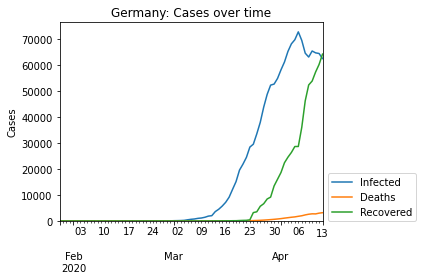

,Date,Confirmed,Infected,Deaths,Recovered
72,2020-04-09,118181,63167,2607,52407
73,2020-04-10,122171,65491,2767,53913
74,2020-04-11,124908,64772,2736,57400
75,2020-04-12,127854,64532,3022,60300
76,2020-04-13,130072,62578,3194,64300


In [10]:
ger_scenario.show_record().tail()

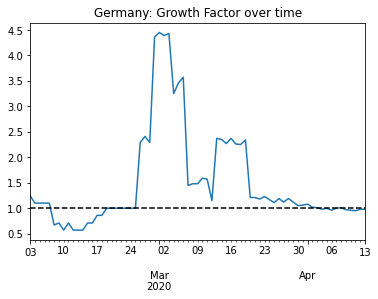

,Date,Group,GF > 1 [straight days],GF < 1 [straight days]
Germany,2020-04-13,Crossroad,0,5


In [11]:
ger_scenario.growth_factor()

In [12]:
ger_scenario.set_phase(
    start_dates=["25Feb2020", "03Mar2020", "11Mar2020","22Mar2020"],
    population=82790000
)

,start_date,end_date,population
1st,25Feb2020,02Mar2020,82790000
2nd,03Mar2020,10Mar2020,82790000
3rd,11Mar2020,21Mar2020,82790000
4th,22Mar2020,-,82790000


In [13]:
ger_scenario.estimate(model.SIR)

Hyperparameter estimation of 1st phase.
	Estimator was created.
		100 trials finished in 0 min 8 sec.
	Successfully estimated.
Hyperparameter estimation of 2nd phase.
	Estimator was created.
		100 trials finished in 0 min 7 sec.
	Successfully estimated.
Hyperparameter estimation of 3rd phase.
	Estimator was created.
		100 trials finished in 0 min 6 sec.
	Successfully estimated.
Hyperparameter estimation of 4th phase.
	Estimator was created.
		100 trials finished in 0 min 7 sec.
	Successfully estimated.
Total: 0 min 29 sec.


../model/model.py:507: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


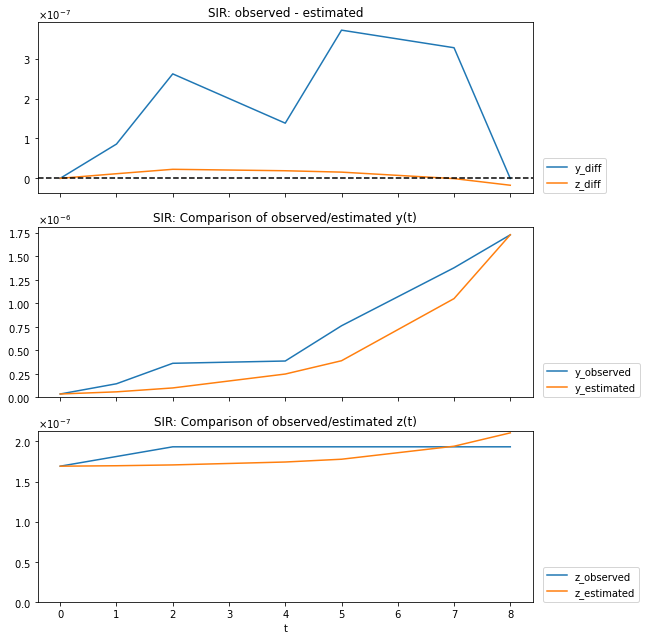

In [17]:
ger_scenario.accuracy_graph(phase_n=1)

../model/model.py:507: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


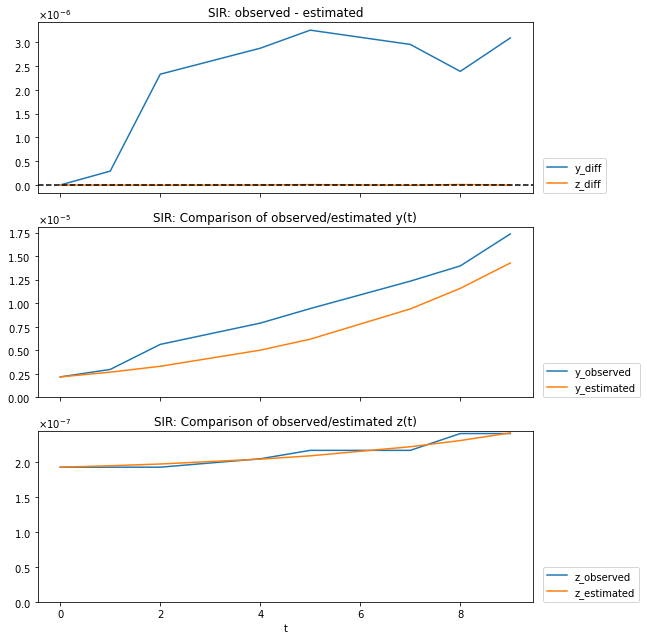

In [18]:
ger_scenario.accuracy_graph(phase_n=2)

../model/model.py:507: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


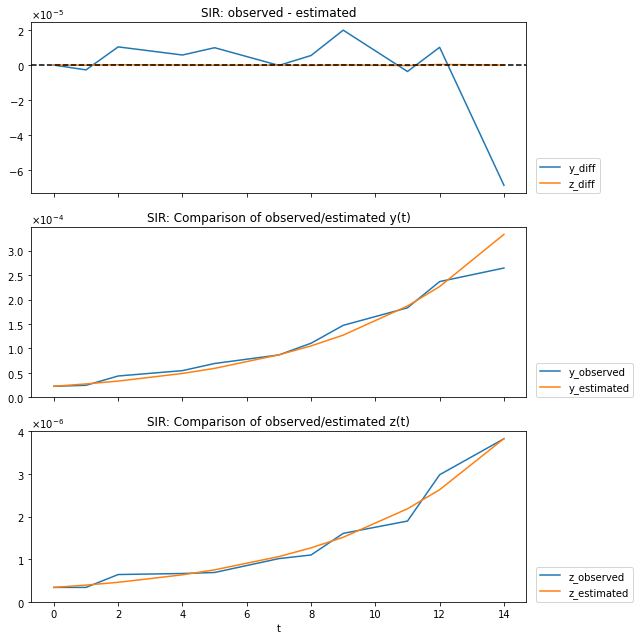

In [19]:
ger_scenario.accuracy_graph(phase_n=3)

../model/model.py:507: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


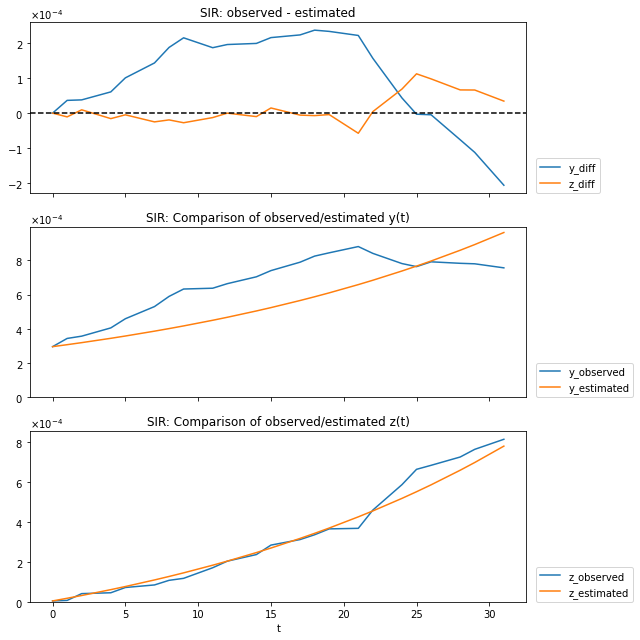

In [20]:
ger_scenario.accuracy_graph(phase_n=4)

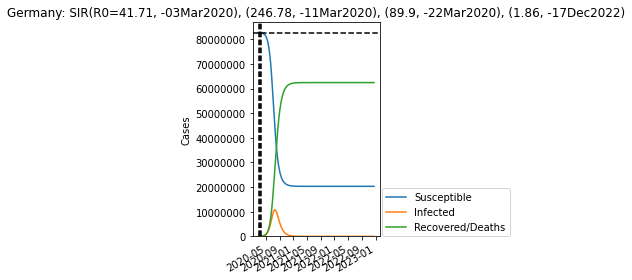

,Susceptible,Infected,Recovered/Deaths
Time,,,
2020-02-25 16:56:00,82789981,4,14
2020-02-26 09:52:00,82789976,9,14
2020-02-27 02:48:00,82789969,16,14
2020-02-27 19:44:00,82789961,23,14
2020-02-28 12:40:00,82789953,32,14
...,...,...,...
2022-12-15 11:12:00,20316216,10,62473772
2022-12-16 04:08:00,20316216,10,62473772
2022-12-16 21:04:00,20316216,10,62473773


In [16]:
ger_scenario.predict(days=1000)